# Predicting number of days until a Department of Buildings Complaint is inspected

#### By: Mahdi Shadkam-Farrokhi & Jeremy Ondov

## Boom's Suggestions:

- <input type="checkbox" checked>Cut at 2009</input>
- <input type="checkbox" checked>Proof seasonality</input>
- <input type="checkbox" checked>SARIMAX w/exog</input>
- <input type="checkbox">Daily is preferable</input>
- <input type="checkbox">Do pull outside daily data best</input>
- <input type="checkbox">Cap at 0 when predicting</input>

## Problem Statement
In New York City, building violations are frequently reported to the Department of Buildings(DOB), which is often initiated by a citizen. However, the length of time between the report and a response by the DOB may vary greatly depending on the location, violation type, and other factors.

We'll be using $R^2$ for model selection.

## Executive Summary
...

## Table of Contents
1. 
2. [Resources](#Resources)


## Loading libraries and data
These data were cleaned from the original source. Please see the accompanying notebook for details on the cleaning process.

In [109]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
import statsmodels.formula.api as smf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier

RANDOM_STATE = 90210

In [110]:
db = pd.read_csv('../datasets/cleaned.csv', index_col = 0, parse_dates = ["date_entered"])

In [111]:
db.head()

,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection,med_inc_zip
complaint_number,,,,,,,,,,,
1245555,CLOSED,2009-01-02,930,10025,WEST END AVENUE,NOT SPECIAL,58,BOILR,2009-06-02,151,82352
1245608,CLOSED,2009-01-02,428,10013,BROADWAY,NOT SPECIAL,23,SCFLD,2009-10-09,280,106056
1245621,CLOSED,2009-01-02,146,10001,WEST 28 STREET,NOT SPECIAL,63,ELEVR,2009-01-22,20,85221
1245634,CLOSED,2009-01-03,388,10013,BROADWAY,NOT SPECIAL,56,BOILR,2009-01-07,4,106056
1245648,CLOSED,2009-01-03,375,10016,3 AVENUE,NOT SPECIAL,59,ELCTR,2009-01-08,5,109250


## Data Cleaning

(Please see accompanying notebook)

SUMMARY OF WHAT WAS CLEANED AND WHY
- Filtered "CLOSED"
- Removed nulls
- Removed invalid dates
- Infered `days_until_inspection`
- Removed negative `days_until_inspection`

### Found oddity in zip codes, which no longer exist

Agreed to drop (not included here)

In [112]:
db[db["zip_code"] == 11211].shape

(1026, 11)

In [113]:
db[db["zip_code"] == 11249].shape

(0, 11)

### Must ensure sorted time order

In [114]:
## 

### Expoloring `med_inc_zip`

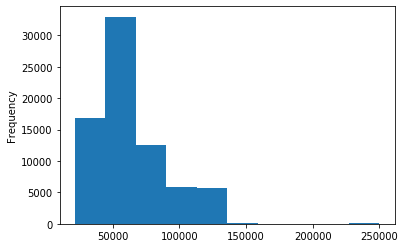

In [115]:
db["med_inc_zip"].plot(kind = "hist")

### Feature engineering log of `med_inc_zip`

In [116]:
db["log_med_inc_zip"] = np.log(db["med_inc_zip"])

### Removing Outliers

(done later - any days_until_insp > 4000)
During model evaluation, we found some significant outliers, which bear consideration.

We've decided to remove these extreme observations from our training set.

In [117]:
db["days_until_inspection"].describe()

count    74340.000000
mean        87.143045
std        209.399509
min          1.000000
25%          5.000000
50%         24.000000
75%         81.000000
max       3767.000000
Name: days_until_inspection, dtype: float64

In [118]:
db.sort_values(by="days_until_inspection", ascending = False).head()

,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection,med_inc_zip,log_med_inc_zip
complaint_number,,,,,,,,,,,,
3305557,CLOSED,2009-05-21,31,11211,DIVISION AVENUE,NOT SPECIAL,31,BKLYN,2019-09-13,3767,66113,11.099121
4392125,CLOSED,2009-03-06,60-09,11365,172 STREET,NOT SPECIAL,45,QNS.,2019-06-18,3756,63455,11.058086
3309361,CLOSED,2009-06-22,263,11222,MC GUINNESS BOULEVARD,NOT SPECIAL,49,SPOPS,2019-07-31,3691,78287,11.268137
4406298,CLOSED,2009-07-01,150-17,11434,LINDEN BOULEVARD,NOT SPECIAL,45,QNS.,2019-07-22,3673,60702,11.013732
3303034,CLOSED,2009-04-28,385,11238,CLASSON AVENUE,NOT SPECIAL,05,BKLYN,2019-04-30,3654,79013,11.277368


In [119]:
db["days_until_inspection"].max() / 365 # converting days to years

10.32054794520548

We can see some extreme DOB complaints took over 10 years to be inspected!

It's hard to tell if these are erroneous or valid, since there are many cases like this.

---
During model evaluation, we found the dat associated with 2009-04-02 to have usual observations with large `days_until_inspection`

In [120]:
outlier_dates = ["2009-04-02"]
db[db["date_entered"].isin(outlier_dates)].sort_values("inspection_date", ascending = False).head()

,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection,med_inc_zip,log_med_inc_zip
complaint_number,,,,,,,,,,,,
2128469,CLOSED,2009-04-02,3031,10463,ARLINGTON AVENUE,NOT SPECIAL,1G,EXCAV,2018-05-19,3334,58881,10.983274
1252772,CLOSED,2009-04-02,315,10017,EAST 46 STREET,NOT SPECIAL,1G,EXCAV,2018-02-16,3242,118469,11.682407
3300206,CLOSED,2009-04-02,150,11211,NORTH 12 STREET,NOT SPECIAL,1G,STALL,2015-10-21,2393,66113,11.099121
3300193,CLOSED,2009-04-02,85,11201,FLATBUSH AVENUE EXTENSION,NOT SPECIAL,1G,EXCAV,2013-03-11,1439,116446,11.665183
3300219,CLOSED,2009-04-02,544,11211,UNION AVENUE,NOT SPECIAL,1G,EXCAV,2012-11-14,1322,66113,11.099121


There may be some association with these exceptionally long inspection times and the `unit` "EXCAV".

As a threshold, we'll remove all observations above 3200 `days_until_inspection`.

In [121]:
outlier_threshold = 3200
db[db["days_until_inspection"] > outlier_threshold].shape

(23, 12)

We find 24 outlier observations, which account for about .03% of the data.

In [122]:
db = db[db["days_until_inspection"] <= outlier_threshold]

## Exploratory Data Analysis

#### Trying log transformation
Skewed distributions can sometimes be coerced to normal using the log transformation. If this is the case with our target, then we may be able to work with a linear regression or other simple model.

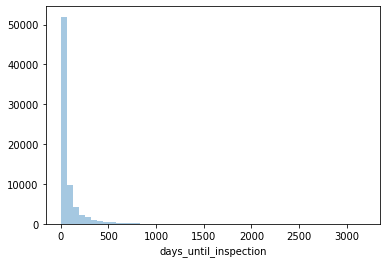

In [123]:
sns.distplot(db["days_until_inspection"], kde = False, bins = 50);

We find a heavily skewed distribution for our target variable, `days_until_inspection`, which is remniscent of an exponential or gamma distribution.

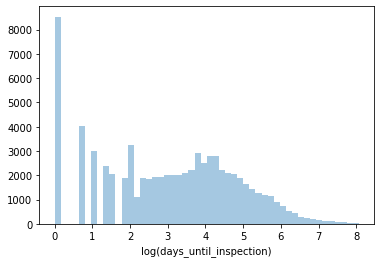

In [124]:
sns.distplot(np.log(db["days_until_inspection"]), axlabel="log(days_until_inspection)", kde = False);

Log transforming our target variable does __not__ result in a normal-looking distribution, so we will keep the target feature as is.

#### Aggregating data by various time intervals

In [125]:
db_with_time_index = db.set_index("date_entered")[["days_until_inspection"]]

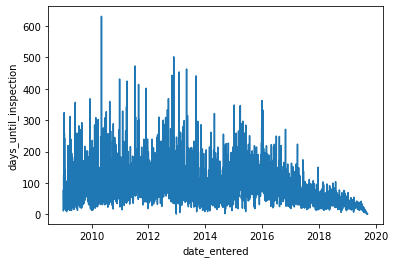

In [126]:
# by day
db_time_by_day = db_with_time_index.resample("D").mean()
sns.lineplot(y = db_time_by_day["days_until_inspection"], x = db_time_by_day.index);

We find after 2016, there appears to be a downward trend in the number of days until a complaint is inspected.

We must consider the recency of the tail end, however, since these complaints are less likely to be "CLOSED" and therefore not seen in the data.

It's difficult to tell if there's any seasonality in these data when aggregating by day.

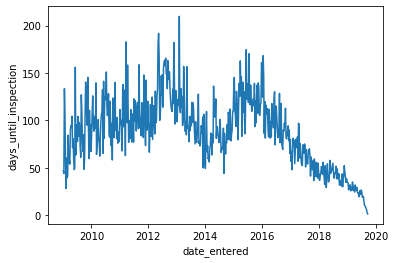

In [127]:
# by week
db_time_by_week = db_with_time_index.resample("W").mean()
sns.lineplot(y = db_time_by_week["days_until_inspection"], x = db_time_by_week.index);

It's difficult to tell if there's any seasonality in these data when aggregating by week.

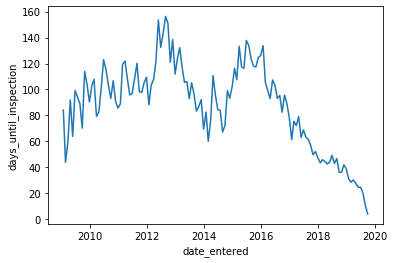

In [128]:
# by month
db_time_by_month = db_with_time_index.resample("M").mean()
sns.lineplot(y = db_time_by_month["days_until_inspection"], x = db_time_by_month.index);

There may be some seasonality by month, though it appears somewhat irregular.

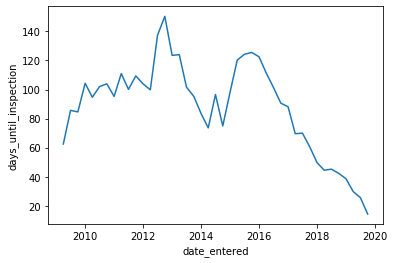

In [129]:
# by quarter
db_time_by_Q = db_with_time_index.resample("Q").mean()
sns.lineplot(y = db_time_by_Q["days_until_inspection"], x = db_time_by_Q.index);

Looking at quarterly aggregations, it's difficult to see a clear regular pattern.

---
We may want to consider testing for seasonality and using an ARIMA or SARIMAX model.

#### Testing for seasonality

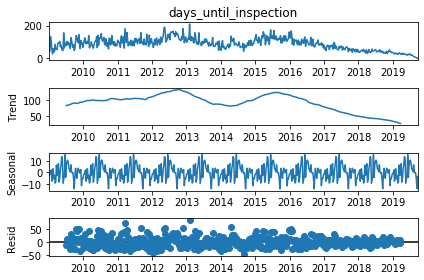

In [130]:
seasonal_decompose(db_time_by_week["days_until_inspection"]).plot()
plt.show()

After decomposing the data we find a seasonal component, which suggests a SARIMAX model may be worth exploring.

### Exploring `Special District`, `Complaint Category` , and `Unit` vs. `days_until_inspection`

In [131]:
def capitalize_words(string):
    '''Returns string with each work capitalized'''
    return " ".join([word.capitalize() for word in string.split()])

In [132]:
def aggregation_plots(db, x, y):
    '''Plots a barplot and boxplot of the given features, limited to top 10 and sorted in descending order'''
    height_per_label = .3
    total_height = len(db[y].unique()[:10]) * height_per_label
    fig, axes = plt.subplots(ncols = 2, figsize = (10, total_height + (2 if total_height< 4 else 0)))
    ax1, ax2 = axes
    
    xlabel = capitalize_words(x.replace("_"," "))
    ylabel = capitalize_words(y.replace("_"," "))
    fig.suptitle("Average {} by {}".format(xlabel,ylabel), y = 1.075)
    
    sorted_label_values = db.groupby(y)[x].agg("mean").sort_values(ascending = False)[:10]

    sns.barplot(ax = ax1, x = db[x], y = db[y], order = sorted_label_values.index)

    ax1.set_ylabel(ylabel)
    ax1.set_xlabel(xlabel)
    
    sns.boxplot(ax = ax2, x = db[x], y = db[y], order = sorted_label_values.index)    
    ax2.set_ylabel(ylabel)
    ax2.set_xlabel(xlabel)
    
    plt.tight_layout()

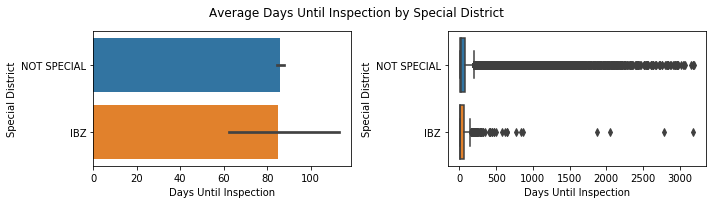

In [133]:
# Special District
aggregation_plots(db, "days_until_inspection", "special_district")

Not seeing much difference in average between Special Districts, however we do see a wide range in individual observations for "NOT SPECIAL" districts.

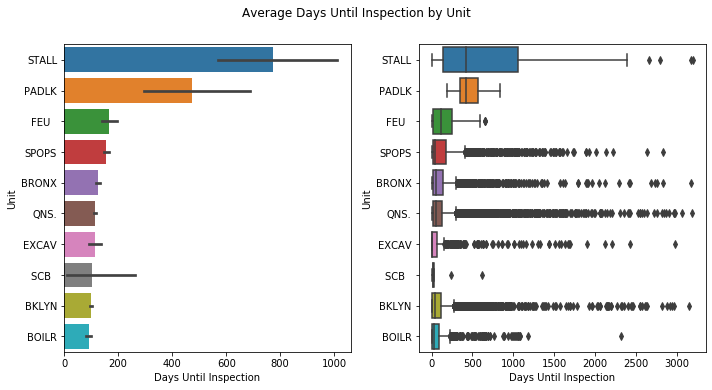

In [134]:
# Unit
aggregation_plots(db, "days_until_inspection", "unit")

The STALL and PADLK units appear to have the longest average days of inspection with little different between the other units. Thos other units, however, have much more extreme ranges.

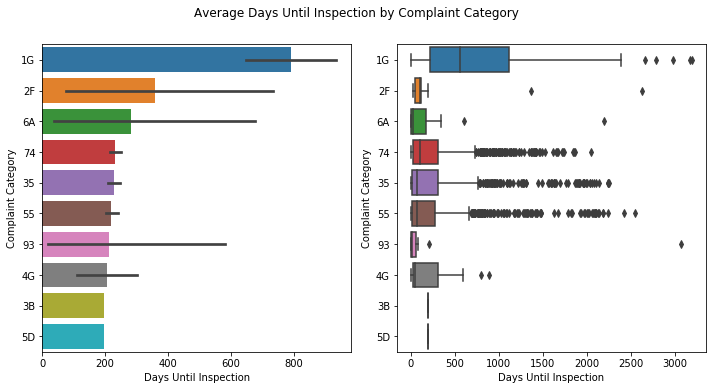

In [135]:
# Complaint Category
aggregation_plots(db, "days_until_inspection", "complaint_category")

The "1G" complaint category appears to take significantly longer to inspect than all other categories, even when taking into account the extreme ranges seen in those categories.

## General Linearized Model (GLM)

### Model Preparation for GLM

Before attempting a SARIMAX model, we'll first explore a general linearized model using the gamma distribution. The target variable, `days_until_inspecti,on`, is bound from $0$ to $\infty$ with an exponentially decreasing frequency.

https://www.statsmodels.org/dev/examples/notebooks/generated/glm.html#GLM:-Gamma-for-proportional-count-response

__Because only using categorical data, this GLM turns into an [ANOVA](https://www.statsmodels.org/dev/anova.html) model__

Therefore, will need to use formula version of GLM because the ANOVA implementation needs to know how categories were formed using the "formula notation" - [source](https://s3.amazonaws.com/assets.datacamp.com/production/course_15356/slides/chapter1.pdf)
- How to use formula notation - [link](https://www.statsmodels.org/dev/examples/notebooks/generated/glm_formula.html)



In [ ]:
db.head()

In [ ]:
target = "days_until_inspection"
glm_features = ["special_district", "complaint_category", "unit", target]
glm_db = db[glm_features]

#### Creating `vizResids` function

`vizResids` is a convenience function to abstract the relevant regression-like model evaluation graphs:
1. True Values ($y$) vs. Predictions ($\hat{y}$)
2. Residuals Plot
3. Residuals Histogram

In [157]:
def vizResids(model_title, target_name,y_true, y_preds):
    resids = y_true - y_preds
    score = r2_score(y_true, y_preds)
    # HANDLING SUBPLOTS
    fig, axes = plt.subplots(2, 2, figsize=(12,10)) # 2 row x 2 columns
    fig.suptitle(f"{model_title}: $R^2$ ={score:2.2%}", fontsize = 24, y = 1.05)

    ax_1 = axes[0][0]
    ax_2 = axes[0][1]
    ax_3 = axes[1][0]

    subplot_title_size = 18
    subplot_label_size = 14
    
    # 1ST PLOT - y_true vs. y_pred
    ax_1.set_title("True Values ($y$) vs. Predictions ($\hat{y}$)", fontsize = subplot_title_size, pad = 10)
    maxDist = max(max(y_preds),max(y_true)) # maxiumum value used to determin x_lim and y_lim
    minDist = min(min(y_preds),min(y_true)) # maxiumum value used to determin x_lim and y_lim
    # 45deg line, signifying prediction == true value
    ax_1.plot((minDist,maxDist),(minDist,maxDist), c = "r", alpha = .7);
    
    sns.scatterplot(ax = ax_1, x = y_true, y = y_preds, alpha = .25)
    ax_1.set_xlabel("True Values ($y$)", fontsize = subplot_label_size, labelpad = 10)
    ax_1.set_ylabel("Predictions ($\hat{y}$)", fontsize = subplot_label_size, labelpad = 10)

    # 2ND PLOT - residuals
    ax_2.set_title("Residuals", fontsize = subplot_title_size)
    sns.scatterplot(ax = ax_2, x = range(len(resids)),y = resids, alpha = .25)
    ax_2.set_ylabel(target_name, fontsize = subplot_label_size)
    ax_2.axhline(0, c = "r", alpha = .7);

    # 3RD PLOT - residuals histogram
    ax_3.set_title("Histogram of residuals", fontsize = subplot_title_size)
    sns.distplot(resids, ax = ax_3, kde = False);
    ax_3.set_xlabel(target_name, fontsize = subplot_label_size)
    ax_3.set_ylabel("Frequency", fontsize = subplot_label_size)

    plt.tight_layout() # handles most overlaping and spacing issues

### Modeling GLM

In [ ]:
glm_gamma = smf.glm(
    formula = "days_until_inspection ~ C(special_district) + C(complaint_category) + C(unit)",
    data = glm_db,
    family = sm.families.Gamma(link = sm.families.links.identity)
).fit()

In [ ]:
glm_gamma.summary()

In [ ]:
vizResids("GLM Results", "Days Until Inspection", glm_db[target], glm_gamma.predict(glm_db))

The GLM model does a poor job of capturing the variance in the model. Much of the failings of this model is likely due to the fact that all of the features are categorical, turning this linear model into something akin to an ANOVA.

According to the summary, almost all of the categorical dummy features are likely insignificant and may suggest our data severely lacks correlation with our target variable. 

## SARIMAX
We've alread seen some seasonality components in our data, which is a motivating reason for exploring a SARIMAX model.

### Model Preparation for SARIMAX

In [136]:
db.head()

,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection,med_inc_zip,log_med_inc_zip
complaint_number,,,,,,,,,,,,
1245555,CLOSED,2009-01-02,930,10025,WEST END AVENUE,NOT SPECIAL,58,BOILR,2009-06-02,151,82352,11.318758
1245608,CLOSED,2009-01-02,428,10013,BROADWAY,NOT SPECIAL,23,SCFLD,2009-10-09,280,106056,11.571723
1245621,CLOSED,2009-01-02,146,10001,WEST 28 STREET,NOT SPECIAL,63,ELEVR,2009-01-22,20,85221,11.353003
1245634,CLOSED,2009-01-03,388,10013,BROADWAY,NOT SPECIAL,56,BOILR,2009-01-07,4,106056,11.571723
1245648,CLOSED,2009-01-03,375,10016,3 AVENUE,NOT SPECIAL,59,ELCTR,2009-01-08,5,109250,11.601394


### Removing outliers
- Anything over 4000 days
- Anything from unit "STALL" or "PADLK"
- Anything from complaint category "1G"

In [137]:
db.shape

(74317, 12)

In [138]:
outlier_mask   = db_with_time_index['days_until_inspection'] < 4000
unit_mask      = db["unit"].isin(["STALL", "PADLK"]) # ignoring these units (take too long) (~62 obs.)
complaint_mask = db["complaint_category"] == "1G" # ignoring this complaint category (takes too long) (~104 obs w/overlap)

In [139]:
target = "days_until_inspection"

## create function to create daily resample of given X and y

# ARIMA SETUP
no_outlier_arima_db = db_with_time_index[outlier_mask.values | unit_mask.values | complaint_mask.values]
weekly_arima_db = no_outlier_arima_db.resample("W").mean().dropna().sort_index()

# EXOGENOUS VARIABLE
sarimax_features = ["special_district","complaint_category","unit","log_med_inc_zip"]
exog = pd.get_dummies(db[outlier_mask.values | unit_mask.values | complaint_mask.values].set_index("date_entered")[sarimax_features]).resample("W").mean().dropna().sort_index()

#### Determining `d` using ADF (Augmented Dickey Fuller) Test

In [140]:
result = adfuller(weekly_arima_db[target])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.053603
p-value: 0.733216
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570


In [141]:
result = adfuller(weekly_arima_db[target].diff(1).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.130676
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570


With a confidence of 95%, we reject the hypothesis the data has no stationarity, therefore we must conclude the data already has stationarity. 

We will not need to difference (`d = 1`).

#### Determining `p` using autocorrelation function

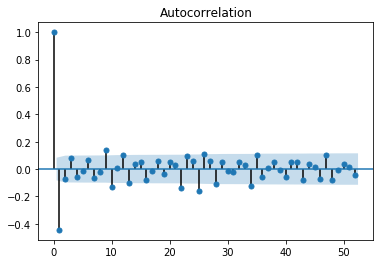

In [147]:
plot_acf(weekly_arima_db[target].diff(1).dropna(), lags=52)
plt.show()

Quick drop at ACF1. p = 0

#### Determining `q` using partial-autocorrelation function

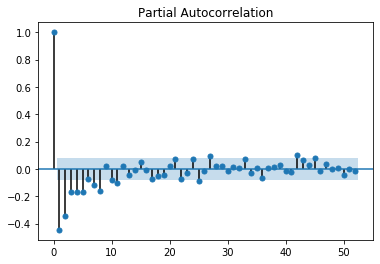

In [148]:
plot_pacf(weekly_arima_db[target].diff(1).dropna(), lags=52)
plt.show()

Again, there is clearly seasonality, therefore difficult to assess the proper value for $q$

#### Verifying `S`, seasonal component

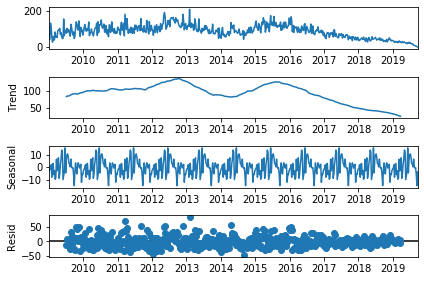

In [144]:
seasonal_decompose(weekly_arima_db, period = 52).plot()
plt.show()

### Using `auto_arima` to determine ARIMA and SARIMAX orders


In [150]:
fitted_sarimax = auto_arima(
    y         = weekly_arima_db,
    exogenous = exog,
    d = 1,
    D = 1,
    start_p = 1, max_p = 1,
    start_q = 0, max_q = 0,
    start_P = 0, max_P = 1,
    start_Q = 0, max_Q = 7,
    m = 52, # daily data
    trace = True,
    error_action = 'ignore',  # don't want to know if an order does not work
    suppress_warnings = True,  # don't want convergence warnings
    random_state = RANDOM_STATE
)

Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=4995.817, BIC=5630.094, Fit time=273.054 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=5034.234, BIC=5664.282, Fit time=20.121 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=4955.036, BIC=5593.541, Fit time=997.819 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 52); AIC=4968.498, BIC=5602.775, Fit time=1413.755 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 52); AIC=4910.888, BIC=5553.621, Fit time=1041.963 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 52); AIC=4955.420, BIC=5593.925, Fit time=1031.665 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 52); AIC=4923.780, BIC=5562.285, Fit time=892.473 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 2, 52); AIC=4918.425, BIC=5565.387, Fit time=3120.099 seconds
Total fit time: 8790.959 seconds


In [151]:
fitted_sarimax.order

(1, 1, 0)

In [152]:
fitted_sarimax.seasonal_order

(1, 1, 1, 52)

### Modeling SARIMAX

In [153]:
sarima = SARIMAX(endog = weekly_arima_db.values,
                 order = fitted_sarimax.order,
                 seasonal_order = fitted_sarimax.seasonal_order,
                 exog = exog.values
                )

fitted_sarima = sarima.fit()

In [154]:
import pickle

In [178]:
# # making new file
# outfile = open("sarimax_pickle", "wb")

# # dumping model to pickle 
# pickle.dump(fitted_sarima, outfile)

# # closing new file
# outfile.close()

In [ ]:
# opening pickle file
infile = open("sarimax_pickle", "rb")

# unpickling back into model object
fitted_sarima = pickle.load(infile)

infile.close()

In [155]:
fitted_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  560
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 52)   Log Likelihood               -2303.444
Date:                              Mon, 09 Mar 2020   AIC                           4910.888
Time:                                      02:56:03   BIC                           5553.621
Sample:                                           0   HQIC                          5162.945
                                              - 560                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0663      0.374     -0.177      0.859      -0.800       0.667
x1             0.9296     35.178      0.026      0.979     -68.018      69.877
x2           203.3199   9.48e+04      0.002      0.998   -1.86e+05    1.86e+05
x3          -203.2987   9.48e+04     -0.002      0.998   -1.86e+05    1.86e+05
x4         -1485.3496   1842.738     -0.806      0.420   -5097.050    2126.351
x5          -215.6698   1691.289     -0.128      0.899   -3530.535    3099.195
x6          -220.2181   1695.466     -0.130      0.897   -3543.271    3102.835
x7           -65.4356   1688.446     -0.039      0.969   -3374.728    3243.857
x8          -129.2070   1700.799     -0.076      0.939   -3462.711    3204.297
x9          -261.9792   1704.882     -0.154      0.878   -3603.486    3079.527
x10         -444.0614   1706.145     -0.260      0.795   -3788.045    2899.922
x11         -426.7756   1720.885     -0.248      0.804   -3799.648    2946.097
x12         3743.4000   3030.379      1.235      0.217   -2196.035    9682.835
x13          -42.1432   1773.720     -0.024      0.981   -3518.571    3434.284
x14         -334.5379   1708.296     -0.196      0.845   -3682.736    3013.660
x15          629.3995   1923.421      0.327      0.743   -3140.436    4399.235
x16         2232.2595   1820.789      1.226      0.220   -1336.422    5800.941
x17         -145.2804   1723.461     -0.084      0.933   -3523.203    3232.642
x18          404.8959   1731.554      0.234      0.815   -2988.887    3798.679
x19         1003.4150   1795.233      0.559      0.576   -2515.177    4522.007
x20          656.2087   1686.944      0.389      0.697   -2650.142    3962.559
x21         -317.4545   1715.402     -0.185      0.853   -3679.580    3044.671
x22          175.2169   1704.345      0.103      0.918   -3165.237    3515.671
x23          362.8831   3190.500      0.114      0.909   -5890.382    6616.148
x24          204.9628   1860.383      0.110      0.912   -3441.320    3851.246
x25           46.8804   1690.265      0.028      0.978   -3265.979    3359.740
x26         2664.4148   6658.229      0.400      0.689   -1.04e+04    1.57e+04
x27         2747.6073   5024.025      0.547      0.584   -7099.301    1.26e+04
x28         -448.0394   9060.916     -0.049      0.961   -1.82e+04    1.73e+04
x29           44.5565   1709.023      0.026      0.979   -3305.067    3394.180
x30           66.4565   1865.776      0.036      0.972   -3590.397    3723.310
x31         -290.1661   1772.941     -0.164      0.870   -3765.067    3184.735
x32         -476.3165   1726.595     -0.276      0.783   -3860.381    2907.748
x33         -470.0404   1705.839     -0.276      0.783   -3813.423    2873.342
x34         -232.5398   1681.972     -0.138      0.890   -3529.144    3064.064
x35         -148.5689   1693.275     -0.088      0.930   -3467.327    3170.189
x36         -303.9203   1800.942  

In [169]:
preds = pd.Series(fitted_sarima.predict())
preds = preds.map(lambda x: x if x > 0 else 0)

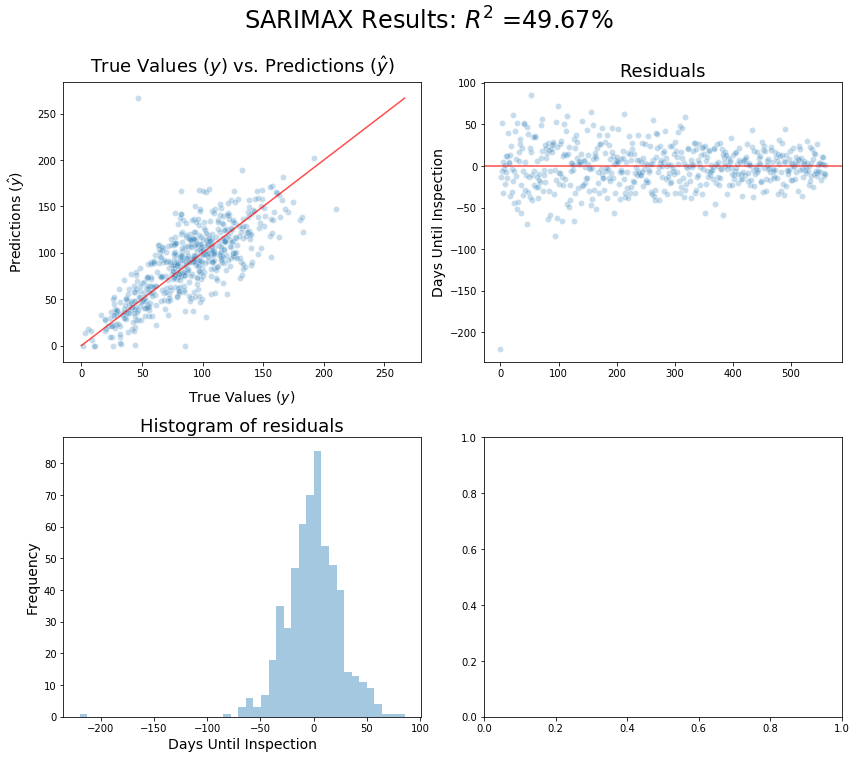

In [172]:
vizResids("SARIMAX Results", "Days Until Inspection", weekly_arima_db[target], preds.values)

In [173]:
from sklearn.metrics import mean_squared_error

In [174]:
rmse = mean_squared_error(weekly_arima_db[target], preds) ** .5

In [177]:
rmse / 30

0.861964140325934

Using RMSE, we can see the model is off, on average, by about 1.74 YEARS!

## Classification Model
By converting target into classes, can simplify model and increase performance

### Model Preparation

In [98]:
def bin_days_until_inspection(days):
    if days <= 7:
        return "within 1 week"
    elif days <= 30:
        return "within 30 days"
    elif days <= 30 * 3:
        return "within 1 quarter"
    elif days <= 30 * 6:
        return "within 6 months"
    elif days <= 365:
        return "within 1 year"
    else:
        return "over 1 year"

In [99]:
db["binned_days_until_inspection"] = db["days_until_inspection"].map(bin_days_until_inspection)

In [100]:
db.head()

,complaint_number,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection,binned_days_until_inspection
1,2193181,CLOSED,2013-12-17,573,10458,EAST FORDHAM ROAD,NOT SPECIAL,4B,SEP,2013-12-24,7,within 1 week
6,1265849,CLOSED,2009-09-21,429,10075,EAST 77 STREET,NOT SPECIAL,73,MAN.,2009-10-03,12,within 30 days
12,1404696,CLOSED,2015-09-02,21,10011,WEST 8 STREET,NOT SPECIAL,37,ERT,2015-09-03,1,within 1 week
13,2149422,CLOSED,2010-08-25,2075,10462,WALLACE AVENUE,NOT SPECIAL,23,ERT,2010-10-09,45,within 1 quarter
14,3312533,CLOSED,2009-07-20,819,11220,59 STREET,NOT SPECIAL,90,CITY,2009-09-15,57,within 1 quarter


In [101]:
keep_cols = ['zip_code', 'special_district', 'complaint_category',
       'unit']

In [102]:
X = pd.get_dummies(db[keep_cols])
y = db['binned_days_until_inspection']

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

### Decision Tree

In [104]:
dt = DecisionTreeClassifier()

In [105]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [106]:
dt.score(X_train, y_train)

0.5291758669957137

In [107]:
dt.score(X_test, y_test)

0.40728654230188494

In [108]:
def pretty_confusion_matrix(y_true, y_pred):
    # handling data
    cm = confusion_matrix(y_true, y_pred)
    labels = y_true.unique()
    labels.sort()
    
    # plotting
    sns.set(font_scale=1.2)
    plt.figure(figsize=(10,4))
    
    sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu",xticklabels=labels, yticklabels=labels, annot_kws={"size": 20})
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')

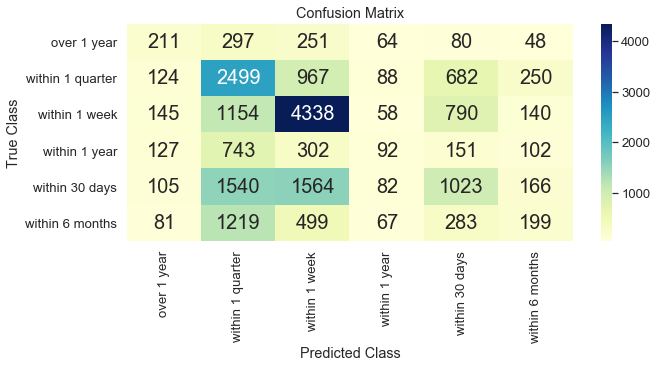

In [110]:
pretty_confusion_matrix(y_test, dt.predict(X_test))

## Adaboost

In [27]:
ada = AdaBoostClassifier()

In [28]:
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [31]:
ada.score(X_train, y_train)

0.41370410051621703

In [32]:
ada.score(X_test, y_test)

0.41453199571442484

## XGBoostClassifier

In [112]:
xgbc = XGBClassifier()

In [113]:
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [114]:
xgbc.score(X_train, y_train)

0.4160280555916353

In [115]:
xgbc.score(X_test, y_test)

0.41551799717500365

## XGBoostRegressor

In [40]:
X = pd.get_dummies(db[keep_cols])
y = db['days_until_inspection']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [46]:
xgbr = XGBRegressor(objective="reg:gamma")

In [47]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:gamma', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [48]:
xgbr.score(X_train, y_train)

0.056975260062927406

In [49]:
xgbr.score(X_test, y_test)

0.06124612728820079

## Model Selection

## Model Evaluation

## Conclusion

## Recommendations

## Resources
- [Data Source](https://data.cityofnewyork.us/Housing-Development/DOB-Complaints-Received/eabe-havv)
- [Complaint Codes](https://www1.nyc.gov/assets/buildings/pdf/complaint_category.pdf)
- [Disposition Codes](https://www1.nyc.gov/assets/buildings/pdf/bis_complaint_disposition_codes.pdf)
- [Data Explains](https://docs.google.com/spreadsheets/d/10p0HLqinKbUrSjKaZC2E0ZTHDXgULT0K/edit#gid=1015257717)